In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.units import pandas_dataframe_to_unit_arrays, units

In [76]:
with open("./radiosoundings/VLMJ_YMC_RS41_isf_20231012_110631.txt", "rb") as fid:
    content = fid.read().decode("ISO-8859-1")

In [77]:
metadata = []
data = []
meta = False
for c in content.splitlines():
    if c.startswith("Metadata"):
        meta = True
        continue
    if meta:
        if c.startswith("Elapsed time"):
            meta = False
            header = c
            continue
    else:
        data.append([d.strip() for d in c.split(",")])

In [78]:
ndf = pd.DataFrame(data[1:], columns=[[h.strip() for h in header.split(",")]])

In [79]:
df  = ndf[["P", "Temp", "Dewp", "Dir", "Speed"]].astype(float)

In [80]:
df = df.rename(columns={
    "P": "pressure",
    "Temp": "temperature",
    "Dewp": "dewpoint",
    "Dir": "direction",
    "Speed": "speed"
}).dropna()

In [81]:
data[0]

['s',
 'm',
 'hPa',
 '°C',
 '%',
 '°C',
 '°',
 'm/s',
 'm',
 'm/s',
 'hPa',
 '°',
 '°',
 '°C',
 '°C',
 '']

In [82]:
p = df['pressure'].values.T[0] * units.hPa
T = df['temperature'].values.T[0] * units.degC
Td = df['dewpoint'].values.T[0] * units.degC
wind_speed = df['speed'].values.T[0] * units.meter_per_second
wind_dir = df['direction'].values.T[0] * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

/jobfs/98106568.gadi-pbs/ipykernel_1656397/1570631207.py:26: UserWarning: Duplicate pressure(s) [12.44 15.19 16.03] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')


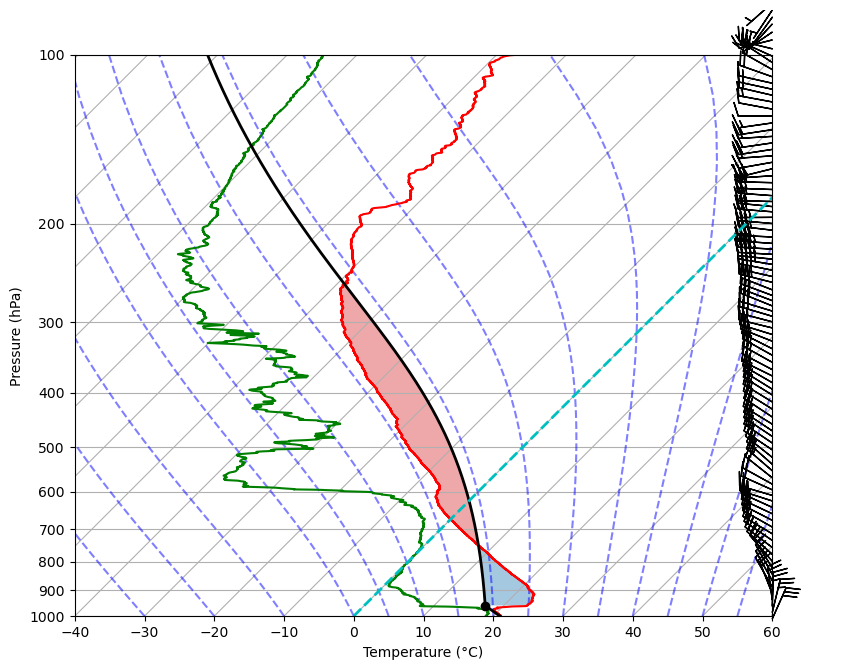

In [83]:
fig = plt.figure(figsize=(9, 9))
# add_metpy_logo(fig, 115, 100)
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::40], u[::40], v[::40])
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Set some better labels than the default
skew.ax.set_xlabel(f'Temperature ({T.units:~P})')
skew.ax.set_ylabel(f'Pressure ({p.units:~P})')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
# skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
# skew.plot_mixing_lines()

# Show the plot
plt.show()
